# Softmax classification with cross-entropy

This tutorial will cover how to do multiclass classification with the [softmax function](#Softmax-function) and [cross-entropy](#Cross-entropy-loss-function-for-the-softmax-function) loss function.

The [previous section]({% post_url 2015-06-10-cross-entropy-logistic %}) described how to represent classification of 2 classes with the help of the [logistic function](http://en.wikipedia.org/wiki/Logistic_function).
For multiclass classification there exists an extension of this logistic function called the [softmax function](http://en.wikipedia.org/wiki/Softmax_function) which is used in [multinomial logistic regression](http://en.wikipedia.org/wiki/Multinomial_logistic_regression). What follows will explain the softmax function and how to derive it.

In [1]:
# Python imports
%matplotlib notebook

import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt  # Plotting library
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from matplotlib import cm # Colormaps
import seaborn as sns  # Fancier plots

# Set seaborn plotting style
sns.set_style('darkgrid')
#

## Softmax function

The [logistic output function](http://en.wikipedia.org/wiki/Logistic_function) described in the previous section can only be used for the classification between two target classes $t=1$ and $t=0$. This logistic function can be generalized to output a multiclass categorical probability distribution by the [softmax function](http://en.wikipedia.org/wiki/Softmax_function). This softmax function $\varsigma$ takes as input a $C$-dimensional vector $\mathbf{z}$ and outputs a $C$-dimensional vector $\mathbf{y}$ of real values between $0$ and $1$. This function is a normalized exponential and is defined as:

$$
y_c = \varsigma(\mathbf{z})_c = \frac{e^{z_c}}{\sum_{d=1}^C e^{z_d}} \quad \text{for} \; c = 1 \cdots C
$$

The denominator $\sum_{d=1}^C e^{z_d}$ acts as a regularizer to make sure that $\sum_{c=1}^C y_c = 1$. 
As the output layer of a neural network, the softmax function can be represented graphically as a layer with $C$ neurons.

We can write the probabilities that the class is $t=c$ for $c = 1 \ldots C$ given input $\mathbf{z}$ as:

$$ 
\begin{bmatrix} 
P(t=1 | \mathbf{z}) \\
\vdots \\
P(t=C | \mathbf{z}) \\
\end{bmatrix}
= \begin{bmatrix} 
\varsigma(\mathbf{z})_1 \\
\vdots \\
\varsigma(\mathbf{z})_C \\
\end{bmatrix}
= \frac{1}{\sum_{d=1}^C e^{z_d}}
\begin{bmatrix} 
e^{z_1} \\
\vdots \\
e^{z_C} \\
\end{bmatrix}
$$

Where $P(t=c | \mathbf{z})$ is thus the probability that that the class is $c$ given the input $\mathbf{z}$.

These probabilities of the output $P(t=1|\mathbf{z})$ for an example system with 2 classes ($t=1$, $t=2$) and input $\mathbf{z} = [z_1, z_2]$ are shown in the figure below. The other probability $P(t=2|\mathbf{z})$ will be complementary.

In [2]:
def softmax(z):
    """Softmax function"""
    return np.exp(z) / np.sum(np.exp(z))

<IPython.core.display.Javascript object>


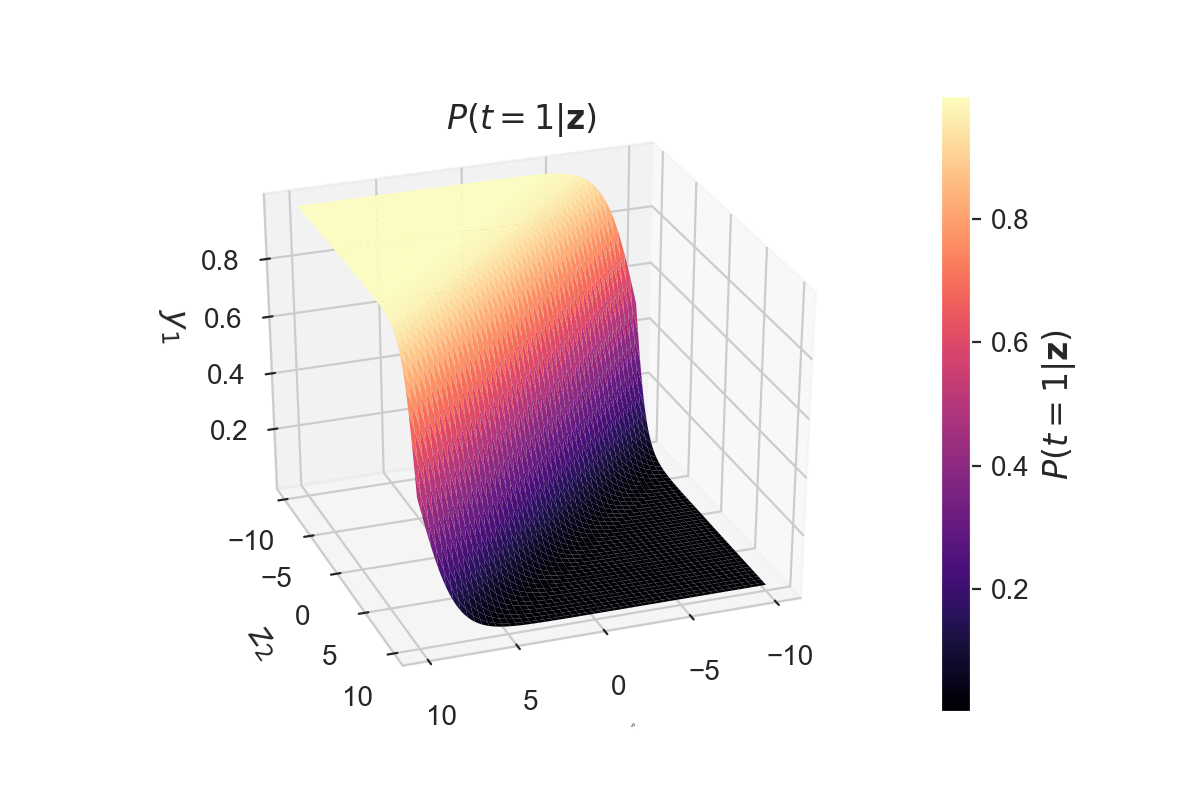

In [3]:
# Plot the softmax output for 2 dimensions for both classes
# Plot the output in function of the weights
# Define a vector of weights for which we want to plot the ooutput
nb_of_zs = 200
zs = np.linspace(-10, 10, num=nb_of_zs) # input 
zs_1, zs_2 = np.meshgrid(zs, zs) # generate grid
y = np.zeros((nb_of_zs, nb_of_zs, 2)) # initialize output
# Fill the output matrix for each combination of input z's
for i in range(nb_of_zs):
    for j in range(nb_of_zs):
        y[i,j,:] = softmax(np.asarray([zs_1[i,j], zs_2[i,j]]))
# Plot the loss function surfaces for both classes
with sns.axes_style("whitegrid"):
    fig = plt.figure(figsize=(6,4))
    # Plot the loss function surface for t=1
    ax = fig.gca(projection='3d')
surf = ax.plot_surface(
    zs_1, zs_2, y[:,:,0], linewidth=0, cmap=cm.magma)
ax.view_init(elev=30, azim=70)
cbar = fig.colorbar(surf)
ax.set_xlabel('$z_1$', fontsize=2)
ax.set_ylabel('$z_2$', fontsize=12)
ax.set_zlabel('$y_1$', fontsize=12)
ax.set_title ('$P(t=1|\mathbf{z})$')
cbar.ax.set_ylabel('$P(t=1|\mathbf{z})$', fontsize=12)
plt.show()
#

### Derivative of the softmax function

To use the softmax function in neural networks, we need to compute its derivative. If we define $\Sigma_C = \sum_{d=1}^C e^{z_d} \, \text{for} \; c = 1 \cdots C$ so that $y_c = e^{z_c} / \Sigma_C$, then this derivative ${\partial y_i}/{\partial z_j}$ of the output $\mathbf{y}$ of the softmax function with respect to its input $\mathbf{z}$ can be calculated as:

$$
\begin{split}
\text{if} \; i = j :& \frac{\partial y_i}{\partial z_i} = \frac{\partial \frac{e^{z_i}}{\Sigma_C}}{\partial z_i} = \frac{e^{z_i}\Sigma_C - e^{z_i}e^{z_i}}{\Sigma_C^2} = \frac{e^{z_i}}{\Sigma_C}\frac{\Sigma_C - e^{z_i}}{\Sigma_C} = \frac{e^{z_i}}{\Sigma_C}(1-\frac{e^{z_i}}{\Sigma_C}) =  y_i (1 - y_i)\\
\text{if} \; i \neq j :& \frac{\partial y_i}{\partial z_j} = \frac{\partial \frac{e^{z_i}}{\Sigma_C}}{\partial z_j} = \frac{0 - e^{z_i}e^{z_j}}{\Sigma_C^2} = -\frac{e^{z_i}}{\Sigma_C} \frac{e^{z_j}}{\Sigma_C} = -y_i y_j
\end{split}$$

Note that if $i = j$ this derivative is similar to the derivative of the logistic function.


### Cross-entropy loss function for the softmax function

To derive the loss function for the softmax function we start out from the [likelihood function](http://en.wikipedia.org/wiki/Likelihood_function) that a given set of parameters $\theta$ of the model can result in prediction of the correct class of each input sample, as in the derivation for the logistic loss function. The maximization of this likelihood can be written as:

$$
\underset{\theta}{\text{argmax}}\; \mathcal{L}(\theta|\mathbf{t},\mathbf{z})
$$

The likelihood $\mathcal{L}(\theta|\mathbf{t},\mathbf{z})$ can be rewritten as the [joint probability](http://en.wikipedia.org/wiki/Joint_probability_distribution) of generating $\mathbf{t}$ and $\mathbf{z}$ given the parameters $\theta$: $P(\mathbf{t},\mathbf{z}|\theta)$. Which can be written as a conditional distribution:

$$
P(\mathbf{t},\mathbf{z}|\theta) = P(\mathbf{t}|\mathbf{z},\theta)P(\mathbf{z}|\theta)
$$

Since we are not interested in the probability of $\mathbf{z}$ we can reduce this to: $\mathcal{L}(\theta|\mathbf{t},\mathbf{z}) = P(\mathbf{t}|\mathbf{z},\theta)$. Which can be written as $P(\mathbf{t}|\mathbf{z})$ for fixed $\theta$.
Since each $t_i$ is dependent on the full $\mathbf{z}$, and only 1 class can be activated in the $\mathbf{t}$ we can write

$$
P(\mathbf{t}|\mathbf{z}) = \prod_{i=c}^{C} P(t_c|\mathbf{z})^{t_c} = \prod_{i=c}^{C} \varsigma(\mathbf{z})_c^{t_c} = \prod_{i=c}^{C} y_c^{t_c}
$$


As was noted during the derivation of the loss function of the logistic function, maximizing this likelihood can also be done by minimizing the negative log-likelihood:

$$-\log \mathcal{L}(\theta|\mathbf{t},\mathbf{z}) 
= \xi(\mathbf{t},\mathbf{z}) = - \log \prod_{i=c}^{C} y_c^{t_c} 
= \sum_{i=c}^{C} t_c \cdot \log(y_c)
$$

Which is the cross-entropy error function $\xi$.
Note that for a 2 class system output $t_2 = 1 - t_1$ and this results in the same error function as for logistic regression: $\xi(\mathbf{t},\mathbf{y}) =- t_c \log(y_c) - (1-t_c) \log(1-y_c) $.

The cross-entropy error function over a batch of multiple samples of size $n$ can be calculated as:

$$
\xi(T,Y) = \sum_{i=1}^n \xi(\mathbf{t}_i,\mathbf{y}_i) = -\sum_{i=1}^n \sum_{i=c}^{C} t_{ic} \cdot \log( y_{ic})
$$

Where $t_{ic}$ is 1 if and only if sample $i$ belongs to class $c$, and $y_{ic}$ is the output probability that sample $i$ belongs to class $c$.

#### Derivative of the cross-entropy loss function for the softmax function

The derivative ${\partial \xi}/{\partial z_i}$ of the loss function with respect to the softmax input $z_i$ can be calculated as:

$$
\begin{split}
\frac{\partial \xi}{\partial z_i} & = - \sum_{j=1}^C \frac{\partial t_j \log(y_j)}{\partial z_i}{} 
= - \sum_{j=1}^C t_j \frac{\partial \log(y_j)}{\partial z_i} 
= - \sum_{j=1}^C t_j \frac{1}{y_j} \frac{\partial y_j}{\partial z_i} \\
& = - \frac{t_i}{y_i} \frac{\partial y_i}{\partial z_i} - \sum_{j \neq i}^C \frac{t_j}{y_j} \frac{\partial y_j}{\partial z_i}
= - \frac{t_i}{y_i} y_i (1-y_i) - \sum_{j \neq i}^C \frac{t_j}{y_j} (-y_j y_i) \\
& = - t_i + t_i y_i + \sum_{j \neq i}^C t_j y_i = - t_i + \sum_{j = 1}^C t_j y_i
= -t_i + y_i \sum_{j = 1}^C t_j \\
& = y_i - t_i
\end{split}
$$

Note that we already derived ${\partial y_j}/{\partial z_i}$ for $i=j$ and $i \neq j$ above.

The result that ${\partial \xi}/{\partial z_i} = y_i - t_i$ for all $i \in C$ is the same as the derivative of the cross-entropy for the logistic function which had only one output node.

In [4]:
# Versions used
print('Python: {}.{}.{}'.format(*sys.version_info[:3]))
print('numpy: {}'.format(np.__version__))
print('matplotlib: {}'.format(matplotlib.__version__))
print('seaborn: {}'.format(sns.__version__))
#

Python: 3.7.0
numpy: 1.15.2
matplotlib: 3.0.0
seaborn: 0.9.0


This is the last part of a 2-part tutorial on classification models trained by cross-entropy:
- [Part 1: Logistic classification with cross-entropy]({% post_url 2015-06-10-cross-entropy-logistic %})
- [Part 2: Softmax classification with cross-entropy (this)]({% post_url 2015-06-10-cross-entropy-softmax %})

This post at <a rel="canonical" href="https://peterroelants.github.io/posts/cross-entropy-softmax/">peterroelants.github.io</a> is generated from an IPython notebook file. [Link to the full IPython notebook file](https://github.com/peterroelants/peterroelants.github.io/blob/master/notebooks/cross_entropy/cross-entropy-softmax.ipynb)